# Windfield Scoring Function and the Neural Network Model
In this notebook I provide examples of how to use the scoring function `validate_windfield()`, as well as reproduce some of my milestone results from experimenting with the neural network model. Note that some of these experiments take long: the ones involving scoring the neural network on 500 time samples take between 3-4 hours.

## Windfield Scoring Function
The windfield scoring function, `validate_windfield()` (found in the module `windfield_validation.py`) is used to estimate the generalization performance of a Windfield model, i.e how well it would perform on previously unseen wind data.  It takes two mandatory arguments:

1. `wind_field` - A Windfield-model (`Class`-object) with public methods defined by a pre-existing framework.
2. `wind_data` - A GeoDataFrame with wind measurements recorded at different times.

### Optional keyword-arguments
There are also four optional keywords:

1. `number_of_samples` - The number of time-slices used for estimating the Windfield's performance (default 500). Needs to be less than or equal to the number of measurements in the `wind_data` frame.
<br/>

2. `verbose` - If `verbose = True`, it prints out the progress (and the current time sample). Default is set to `False`. 
<br/>

3. `get_history` - This is only applicable to the `MLPWindfield` (neural network) model. If set to `True`, then the `validate_windfield()`-function returns two objects: one pandas dataframe containing the final performance statistics, as well as another dataframe containing the mean performance of various metrics, such as root mean square error (RMSE) and $R^2$, recorded throughout the training process of the neural network as functions of the number of epochs. If `get_history = False`, then the function returns a single dataframe with the final mean RMSE and $R^2$ performance statistics. Default is `False`.
<br/>

4. `seed` - This sets the seed in the random number generator, to make results reproducable. Needs to be an `int`, or `None`. Default is `None`. 
<br/>

5. `min_stations` - When, sampling, ignore measurements for which there are less than `min_stations` number of stations. Default is `min_stations = 10`.

### Scoring
The RMSE score is defined as the square root of the k-fold cross-validated absolute squared error score (with k = 5), averaged over the $N$ time samples. The $R^2$ score is the fraction of explained variance, and is here estimated as 

\begin{align}
R^2 =  1 - \frac{\text{MSE}_{\text{Windfield}}}{\frac{1}{N}\sum_{i = 1}^{N}\frac{1}{M_i} \sum_{ j = 1}^{M_i} |\mathbf{u}_{ij}|^{2}}
\end{align}

where $\text{MSE}_{\text{Windfield}}$ is the mean cross-validated mean square error of the given Windfield-model, $\mathbf{u}_{ij}$ is the true wind vector in training point $j$ of time sample $i$, $N$ = `number_of_samples` is the number of time samples, and $M_i$ is the number of training points (stations) in time sample $i$. The uncertainties, $\Delta$, for the performance measures are taken as the standard error of the mean value of each measure, for example:

\begin{align}
\Delta_{\text{RMSE}} = \frac{\sigma_{\text{RMSE}}}{\sqrt{N}},
\end{align}
is the uncertainty for the mean RMSE measure and $\sigma_{\text{RMSE}}$ is the sample standard deviation of the RMSE measure, calculated over the $N$ samples.


### Examples

We will begin by loading all the necessary modules:

In [4]:
# We want to work with modules from parent directory
import sys
sys.path.append('../')

# Models:
from models.averaging_windfield import AveragingWindfield
from models.mlp_windfield import MLPWindfield

# Prediction error and uncertainty functions:
from error_estimation.windfield_validation import validate_windfield
from error_estimation.windfield_validation import best_results_from_history

# Some of the data loading functions produce warnings,
# Let's supress them for neatness sake.
import warnings
warnings.filterwarnings("ignore")

# Tools:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import framework.data_loader as dl
from framework.windfield import WindDataFrame
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

Load the wind data as a GeoDataFrame using the `dl` module. The code below will load a full year of data from 2018:

In [5]:
wind_data_2018: WindDataFrame = dl.load_parquet("../Data/wind_data_2018.parquet")
#wind_data_2018 # Un-hash to display the columns in the wind_data GeoDataFrame.

To score a given Windfield-model, call the `validate_windfield()`. Below is an example using the `AveragingWindfield`-model:

In [6]:
result = validate_windfield(AveragingWindfield(), wind_data_2018, number_of_samples = 1)

Let's plot the results:

In [8]:
print("\n Results:")
print(result.to_markdown())


 Results:
|    | measure   |    score |   stddev |
|---:|:----------|---------:|---------:|
|  0 | RMSE      | 2.78294  |      nan |
|  1 | R^2       | 0.525255 |      nan |




In the above example, only 1 time sample was used, which means that the validation function only used a single time-sample of wind data to calculate the `RMSE` and `R^2` scores. For `number_of_samples` $\geq$ `2` , the `validate_windfield()`-function calculates mean values of the `RMSE` and `R^2` scores, and also calculates the standard deviations for each mean. Below is an example for `number_of_samples = 5`

In [9]:
result = validate_windfield(AveragingWindfield(), wind_data_2018, number_of_samples = 5)

Plot the results:

In [10]:
print("\n Results:")
print(result.to_markdown())


 Results:
|    | measure   |    score |    stddev |
|---:|:----------|---------:|----------:|
|  0 | RMSE      | 2.8683   | 0.105111  |
|  1 | R^2       | 0.569552 | 0.0608249 |


Because the `stddev` (or "standard error") of the mean RMSE value is inversely proportional to $\sqrt{N}$, using a larger `number_of_samples` naturally produce smaller uncertainties in the scores. Below is an example for `number_of_samples = 500`. Due to the stochasticity involved in running these experiments, in order to make it reproducible I will hereafter use a random seed:

In [11]:
result = validate_windfield(AveragingWindfield(), wind_data_2018, number_of_samples = 500, seed = 133)

Plot the results:

In [13]:
print("\n Results:")
print(result.to_markdown())


 Results:
|    | measure   |    score |    stddev |
|---:|:----------|---------:|----------:|
|  0 | RMSE      | 2.65221  | 0.0251101 |
|  1 | R^2       | 0.610041 | 0.0140699 |


## Neural Network Model Windfield

Next, we'll run experiments with the `MLPWindfield` (neural network) model. One of the goals this summer has been to get a `MLPWindfield` model to perform better than the AveragingWindfield model. TensorFlow's Keras was used in the implementation of the neural network. The "base" `MLPWindfield` model that I started out with used 1 hidden layer of 20 neurons, with the default parameters and learning rate of the Adam optimizer, ReLU activation-functions and MSE loss; however, it is possible to tinker around with the learning rate of the optimizer, as well as trying other activation-functions available through Keras by passing the keyword-arguments `learning_rate` and `activation` when instantiating the `MLPWindfield`.

 As mentioned above, when instantiating the `MLPWindfield` model, a range of different keyword arguments can be passed  (running `help(MLPWindfield)` provides a list of all the available keyword-arguments, as well as some basic example usages). The `l2` and `gamma` parameters are used in regularization schemes that are not included in this baseline model, and will be covered later on, so for now we set them to 0. The keyword `N` sets the number of times throughout the training that the test error is recorded. A larger `N` will thus give slower performance. Since this model uses elevation data as a third input feature, the `elevation` keyword needs to be set to `True` and an `altitude_lookup` function needs to be added, as exemplified by the code below; running it will instantiate a `MLPWindfield` class object.

In [14]:
MLP_wind_field = MLPWindfield(epochs=1000,
                              learning_rate=0.001,
                              layers=[20,2],
                              elevation=True,
                              l2 = 0.,
                              gamma=0.,
                              N=10)

MLP_wind_field.altitude_lookup = MLPWindfield.make_altitude_lookup(wind_data_2018)

We are now ready to benchmark this model. As mentioned above, setting the keyword `get_history = True` in the argument of the `validate_windfield()`-function allows the user to gather useful information about how the performance statistics changes throughout the training process. 

In [15]:
res_1, history_1 = validate_windfield(MLP_wind_field, 
                                    wind_data_2018, 
                                    number_of_samples = 500,
                                    get_history = True,
                                    seed = 133)

In [16]:
print("\n Results:")
print(res_1.to_markdown())


 Results:
|    | measure   |    score |   stddev |
|---:|:----------|---------:|---------:|
|  0 | RMSE      | 3.54119  | 1.15523  |
|  1 | R^2       | 0.750605 | 0.234321 |


Hence, this "baseline" MLP model already scores slightly better than the `AveragingWindfield` model, but the results are still within each model's error bounds. Since we opted to record the training histories, we may also plot a graph of how the training error and test (generalization) error of the model evolves during training:

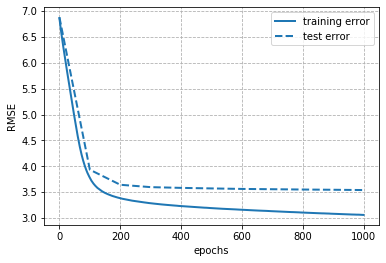

In [17]:
plt.plot(history_1['train_loss'], color = '#1f77b4', label = 'training error', linewidth = 2)

plt.plot(np.linspace(0,len(history_1['train_loss']), 11), history_1['test_loss'][~np.isnan(history_1['test_loss'])], 
                                                             color = '#1f77b4',
                                                             label = 'test error', 
                                                             linestyle = 'dashed',
                                                             linewidth = 2)
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid(linestyle = 'dashed')
plt.show()

Since there are no obvious signs of "overfitting" (in the sense that the generalization error might start to increase as the training error decreases), it led me to test more complex models, with more hidden neurons, and multiple layers. I tried the following configurations:

* One layer: 20, 40, 80 or 160 neurons in the hidden layer.
* Two layers: 20, 40, 80 or 160 neurons in each hidden layer.
* Three layers: 10, 20 or 40 neurons in each hidden layer. 

A new best model was found using 3 hidden layers with 20 neurons in each hidden layer (represented by the array `[20,20,20,2]`, where `2` corresponds ot the output layer). The code below scores this best model over 500 samples using the `validate_windfield()`-function.

In [18]:
MLP_wind_field = MLPWindfield(epochs=1000,
                              learning_rate=0.001,
                              layers=[20,20,20,2], #<--- 2 additional hidden layers.
                              elevation=True,
                              l2 = 0.,
                              gamma=0.,
                              N=10)

MLP_wind_field.altitude_lookup = MLPWindfield.make_altitude_lookup(wind_data_2018)

In [19]:
res_2, history_2 = validate_windfield(MLP_wind_field, 
                                    wind_data_2018, 
                                    number_of_samples = 500, 
                                    get_history = True,
                                    seed = 133)

Let us plot the results:

In [20]:
print("\n Results:")
print(res_2.to_markdown())


 Results:
|    | measure   |    score |   stddev |
|---:|:----------|---------:|---------:|
|  0 | RMSE      | 3.53519  | 1.00538  |
|  1 | R^2       | 0.757188 | 0.218792 |


At a first glance, the model appears to have gotten *worse*. But let's dig a little deeper by plotting the history. This time, we'll compare the normalized $R^2$ scores between the baseline model and this new, more complex, model.

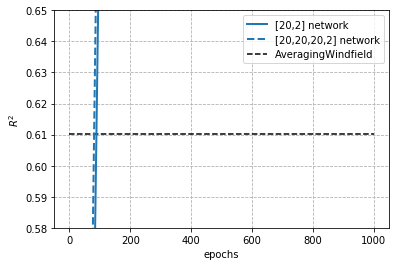

In [21]:
plt.plot(np.linspace(0,len(history_1['test_loss']), 11), history_1['R^2'][~np.isnan(history_1['R^2'])], 
                                                         color = '#1f77b4',
                                                         label = '[20,2] network', 
                                                         linewidth = 2)

plt.plot(np.linspace(0,len(history_1['test_loss']), 11), history_2['R^2'][~np.isnan(history_2['R^2'])], 
                                                         color = '#1f77b4',
                                                         label = '[20,20,20,2] network', 
                                                         linestyle = 'dashed',
                                                         linewidth = 2)

plt.hlines(0.610041, 0, 1000, linestyle = 'dashed', label= 'AveragingWindfield')
plt.xlabel('epochs')
plt.ylabel('$R^2$')
plt.ylim([0.58,0.65])
plt.legend()
plt.grid(linestyle = 'dashed')
plt.show()

Indeed, these history plots reveal that 1000 `epochs` is far from ideal in this case as the model begins to overfit after around 400 `epochs`. This explains why the results seemed to get *worse* with this model setup, and it also showcases the importance of being able to track the evolution of the model's generalization performance throughout training: note that at the peak, around 300-400 `epochs`, the performance is much better. 

### Function: `best_results_from_history()`

Calling `best_results_from_history(history)` allows the user to return the epoch corresponding to the best scores recorded throughout training, as well as a pandas dataframe holding these best scores:

In [22]:
best_epoch_2, best_results_2 = best_results_from_history(history_2)
print('Best network performance, using early stopping at',best_epoch_2,'epochs:')
print(best_results_2.to_markdown())

Best network performance, using early stopping at 499 epochs:
|    | measure   |    score |   stddev |
|---:|:----------|---------:|---------:|
|  0 | RMSE      | 3.5014   | 1.05942  |
|  1 | R^2       | 0.759456 | 0.220773 |


Given the tendency of overfitting, the next step was to apply a type of regularization. This was done using [TensorFlow's $L^2$-kernel regularizer](https://keras.io/api/layers/regularizers/#l2-class) applied to all the hidden layers of the network. I tried the values of the `l2`-parameter $\in$ \{0.0001,0.001,0.01,0.1\}. Setting the `l2`-parameter to `l2 = 0.01` gave the best results. We can re-run the `validate_windfield()` with this added regularization and compare the results:

In [23]:
MLP_wind_field = MLPWindfield(epochs=1000,
                              learning_rate=0.001,
                              layers=[20,20,20,2],
                              elevation=True,
                              l2 = 0.01, #<--- added non-zero L^2-regularization parameter.
                              gamma=0.,
                              N=10)

MLP_wind_field.altitude_lookup = MLPWindfield.make_altitude_lookup(wind_data_2018)

In [24]:
res_3, history_3 = validate_windfield(MLP_wind_field, 
                                    wind_data_2018, 
                                    number_of_samples = 500, 
                                    get_history = True,
                                    seed = 133)

In [25]:
print("\n Results:")
print(res_3.to_markdown())


 Results:
|    | measure   |   score |   stddev |
|---:|:----------|--------:|---------:|
|  0 | RMSE      | 3.45109 | 1.03052  |
|  1 | R^2       | 0.76683 | 0.213154 |


Plotting and comparing the results:

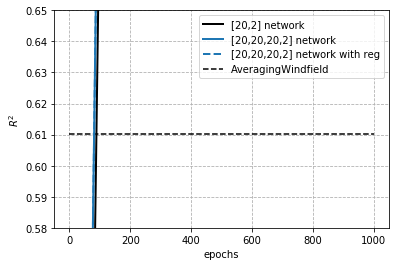

In [26]:
plt.plot(np.linspace(0,len(history_1['test_loss']), 11), history_1['R^2'][~np.isnan(history_1['R^2'])], 
                                                         color = 'black',
                                                         label = '[20,2] network', 
                                                         linewidth = 2)

plt.plot(np.linspace(0,len(history_1['test_loss']), 11), history_2['R^2'][~np.isnan(history_2['R^2'])], 
                                                         color = '#1f77b4',
                                                         label = '[20,20,20,2] network', 
                                                         linestyle = 'solid',
                                                         linewidth = 2)

plt.plot(np.linspace(0,len(history_1['test_loss']), 11), history_3['R^2'][~np.isnan(history_2['R^2'])], 
                                                         color = '#1f77b4',
                                                         label = '[20,20,20,2] network with reg', 
                                                         linestyle = 'dashed',
                                                         linewidth = 2)

plt.hlines(0.610041, 0, 1000, linestyle = 'dashed', label= 'AveragingWindfield')
plt.xlabel('epochs')
plt.ylabel('$R^2$')
plt.ylim([0.58,0.65])
plt.legend()
plt.grid(linestyle = 'dashed')
plt.show()

Again, this gave a new best performing model. The regularized network has a flatter training curve and the peak performance here occurs at around 500 `epochs`:

In [27]:
best_epoch_3, best_results_3 = best_results_from_history(history_3)

print('Best network performance, using early stopping at',best_epoch_3,'epochs:')
print(best_results_3.to_markdown())

Best network performance, using early stopping at 699 epochs:
|    | measure   |    score |   stddev |
|---:|:----------|---------:|---------:|
|  0 | RMSE      | 3.43957  | 1.06429  |
|  1 | R^2       | 0.766985 | 0.215334 |


The neural network model scores better than the `AveragingWindfield`-model: $R^2_{\text{MLP}} = 0.63 \pm 0.01$ versus $R^2_{\text{avg}} = 0.61 \pm 0.01$. This new neural network model also trains twice as fast as the baseline model. In an attempt to improve the network model further, a custom loss
function was implemented that added a term which punishes non-zero divergence. 

### Custom Loss Function with a Divergence Constraint

The training of a neural network is synonymous to minimizing a "loss-function". The MLPWindfield-network uses the so-called "mean squared error loss", which is common for regression problems. Given $N$ training station in a given wind field time-sample, the mean squared loss can be written:
\begin{align}
\mathcal{L}_\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} |\vec{u}_{\text{pred}, i} - \vec{u}_{\text{true}, i}|^{2}
\end{align}
where $\vec{u}_{\text{true},i }$ is the actual wind vector in data point (meteorological station) $i$ and $\vec{u}_{\text{pred}, i}$ is the corresponding predicted wind vector. First off, note that if the predicted wind and the true wind are *close*, then the loss will be *small*. Secondly, note that $\vec{u}_\text{pred,i}$ (and thus the loss function) depends on the particular network parameters (often referred to as the "weights" and "biases"). Thus, the standard way of "training" the neural network is to run som variant of gradient descent in order to minimize the loss function with respect to these network parameters (this is a high-level description of what is going on; to learn more, there is a decent online [deep learning book](https://www.deeplearningbook.org/)).

In order to incorporate a divergence constraint, we can *append* this loss function with a term that is proportional to the divergence of the wind field:

\begin{align}
\mathcal{L}_{\text{custom}} = \mathcal{L}_\text{MSE} + \gamma \frac{1}{N} \sum_{i = 1}^{N} |(\nabla \cdot \vec{u})_i | = \mathcal{L}_\text{MSE} + \mathcal{L}_\text{div},
\end{align}
where $\gamma$  can be viewed as controlling the relative importance given to minimizing the divergence. Numerically,  the divergence loss is calculated by for every meteorological station introducing 4 surrounding "grid-points" with which the divergence in each station can be estimated using finite differences.

Let
\begin{align}
    x' = \frac{x-\bar{x}}{\sigma_x}\\
    y' = \frac{y-\bar{y}}{\sigma_y}
\end{align}
be the scaled coordinates of $x,y$ of each station $P$ (where $\sigma_x$, $\sigma_y$ are the standard deviations of $x$ and $y$ respectively). This is a standard way of normalizing the input data. Also let $p_1$, $p_2$, $p_3$, and $p_4$ denote the points surrounding each station $P$, where $p_1$ is west, $p_2$ is north, $p_3$ is east, $p_4$ is south of $P$ respectively. Thus each of these surrounding points lies at a distance $h$ away from $P$ either in the $x$- or $y$-direction (my implementation uses $h = 10$ m. Then for each station $P$, the chain-rule gives:
\begin{align}
    (\nabla \cdot \vec{u})_P =  \frac{\partial u}{\partial x'} \frac{\partial x'}{\partial x} +  \frac{\partial v}{\partial y'} \frac{\partial y'}{\partial y} &= \frac{\partial u}{\partial x'}\frac{1}{\sigma_x} +  \frac{\partial v}{\partial y'} \frac{1}{\sigma_y} \approx \bigg( \frac{u_{p_1} - u_{p_3}}{x'_1 - x'_3}\bigg)\frac{1}{\sigma_x} + \bigg( \frac{v_{p_2} - v_{p_4}}{y'_2 - y'_4}\bigg)\frac{1}{\sigma_y}.
\end{align}
Lastly, we make it independent of the scale in the $x,y$-coordinates:
\begin{align}
    \Big(\frac{\sigma_x + \sigma_y}{2}\Big) (\nabla \cdot \vec{u})_P \approx \Big(\frac{\sigma_x + \sigma_y}{2}\Big)\bigg[ \bigg( \frac{u_{p_1} - u_{p_3}}{x'_1 - x'_3}\bigg)\frac{1}{\sigma_x} + \bigg( \frac{v_{p_2} - v_{p_4}}{y'_2 - y'_4}\bigg)\frac{1}{\sigma_y} \bigg].
\end{align}

Note that the wind components in the expression for the divergence are taken from the *predicted* wind vector field. I found that, out of the values $\gamma \in \{0.0001,0.001,0.005,0.01,0.015,0.1\}$, $\gamma = 0.01$ gave the best performance:



In [28]:
MLP_wind_field = MLPWindfield(epochs=1000,
                              learning_rate=0.001,
                              layers=[20,20,20,2],
                              elevation=True,
                              l2 = 0.01,
                              gamma=0.01, #<--- new non-zero div-parameter
                              N=10)

MLP_wind_field.altitude_lookup = MLPWindfield.make_altitude_lookup(wind_data_2018)

In [ ]:
res_4, history_4 = validate_windfield(MLP_wind_field, 
                                    wind_data_2018, 
                                    number_of_samples = 500,
                                    get_history = True,
                                    seed = 133)

In [ ]:
plt.plot(np.linspace(0,len(history_1['test_loss']), 11), history_1['R^2'][~np.isnan(history_1['R^2'])], 
                                                         color = 'black',
                                                         label = '[20,2] network (baseline)', 
                                                         linewidth = 2)

plt.plot(np.linspace(0,len(history_1['test_loss']), 11), history_2['R^2'][~np.isnan(history_2['R^2'])], 
                                                         color = '#1f77b4',
                                                         label = '[20,20,20,2] network', 
                                                         linestyle = 'solid',
                                                         linewidth = 2)

plt.plot(np.linspace(0,len(history_1['test_loss']), 11), history_3['R^2'][~np.isnan(history_2['R^2'])], 
                                                         color = '#1f77b4',
                                                         label = '[20,20,20,2] with L^2-reg', 
                                                         linestyle = 'dashed',
                                                         linewidth = 2)
plt.plot(np.linspace(0,len(history_1['test_loss']), 11), history_4['R^2'][~np.isnan(history_2['R^2'])], 
                                                         color = 'red',
                                                         label = '[20,20,20,2] with L^2- and div-reg', 
                                                         linestyle = 'solid',
                                                         linewidth = 2)

plt.hlines(0.610041, 0, 1000, linestyle = 'dashed', label= 'AveragingWindfield')
plt.xlabel('epochs')
plt.ylabel('$R^2$')
plt.ylim([0.605,0.64])
plt.legend()
plt.grid(linestyle = 'dashed')
plt.show()

There looks to be a new peak at 600 epochs. Again we can check the best results throughout training:

In [ ]:
best_epoch_4, best_results_4 = best_results_from_history(history_3)

print('Best network performance, using early stopping at',best_epoch_3,'epochs:')
print(best_results_4.to_markdown())

This is the best performing model that I managed to find during my work this summer. Because the history-curves were flattened by regularization, I subsequently went ahead and tried more complex models with layers `[30,30,30,2]` and `[40,40,40,2]`; however, this did not improve the performance. It might be worth experimenting with new ranges of regularization-parameters, or trying to add more layers instead of the number of neurons in each layer - that is, increasing the depth rather than the width of the network. Another thing that might be worth trying is to apply the divergence constraint not to the training points themselves, but to points randomly generated across the map of Sweden. Of course, other than the two regularization-techniques I have employed in my work, there is a plethora of other ways of regularizing, "dropout" for example. This might also be worth pursuing.